<a href="https://colab.research.google.com/github/dhanu902/FoodieChat-Bot/blob/main/BOT_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### List content

In [3]:
!ls /content/drive/MyDrive/ChatBot/MultiWOZ_2.2/train

dialogues_001.json  dialogues_006.json	dialogues_011.json  dialogues_016.json
dialogues_002.json  dialogues_007.json	dialogues_012.json  dialogues_017.json
dialogues_003.json  dialogues_008.json	dialogues_013.json
dialogues_004.json  dialogues_009.json	dialogues_014.json
dialogues_005.json  dialogues_010.json	dialogues_015.json


##### Combine all train data into one File

In [4]:
train_path = '/content/drive/MyDrive/ChatBot/MultiWOZ_2.2/train'

In [5]:
import json
import os

train_data = {}

for filename in sorted(os.listdir(train_path)):
  if filename.endswith('.json'):
    with open(os.path.join(train_path, filename), 'r') as f:
      dialogues = json.load(f)
      for dialogue in dialogues:
        train_data[dialogue['dialogue_id']] = dialogue

print(f"Total dialogues loaded: {len(train_data)}")

Total dialogues loaded: 8437


#***EDA***

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Total no.of Dialogues

In [7]:
print(f"Total Dialogues: {len(train_data)}")

Total Dialogues: 8437


#### Structure of single dialogue

In [8]:
sample_key = list(train_data.keys())[0]
sample_dialogue = train_data[sample_key]
print(json.dumps(sample_dialogue, indent=2))

{
  "dialogue_id": "PMUL4398.json",
  "services": [
    "restaurant",
    "hotel"
  ],
  "turns": [
    {
      "frames": [
        {
          "actions": [],
          "service": "restaurant",
          "slots": [],
          "state": {
            "active_intent": "find_restaurant",
            "requested_slots": [],
            "slot_values": {
              "restaurant-area": [
                "centre"
              ],
              "restaurant-pricerange": [
                "expensive"
              ]
            }
          }
        },
        {
          "actions": [],
          "service": "taxi",
          "slots": [],
          "state": {
            "active_intent": "NONE",
            "requested_slots": [],
            "slot_values": {}
          }
        },
        {
          "actions": [],
          "service": "train",
          "slots": [],
          "state": {
            "active_intent": "NONE",
            "requested_slots": [],
            "slot_values": {}
       

---

 ✅ What This Dialogue Contains:

| **Key**       | **Value**                                |
| ------------- | ---------------------------------------- |
| `dialogue_id` | `PMUL4398.json`                          |
| `services`    | `["restaurant", "hotel"]` (multi-domain) |
| `turns`       | `12 dialogue turns` (user + system)      |

---

 💬 Example of the Interaction:

1. 🧑 **User**: I need a place to dine in the center that's expensive
   🤖 **Bot**: I have several options... do you prefer African, Asian, or British food?

2. 🧑 **User**: Any food is fine... can I get the phone number?
   🤖 **Bot**: There is a place named **Bedouin**... phone is **01223367660**...

---

 🧠 Key NLP Annotations:

* **Intents**: `find_restaurant`, `book_hotel`
* **Slot Values**:

  * `"restaurant-pricerange"`: `"expensive"`
  * `"restaurant-area"`: `"centre"`
  * `"restaurant-name"`: `"bedouin"`
  * `"restaurant-phone"`: `"01223367660"`

---

#### Domain Frequency

In [9]:
services_counter = {}
turn_per_dialogue = []
domains_in_dialogue = []

for dialogue in train_data.values():
  services = dialogue.get("services", [])
  for service in services:
    services_counter[service] = services_counter.get(service, 0) + 1
  domains_in_dialogue.append(services)
turn_per_dialogue.append(len(dialogue.get("turns", [])))

services_df = pd.DataFrame(list(services_counter.items()), columns=["Domain", "Count"])

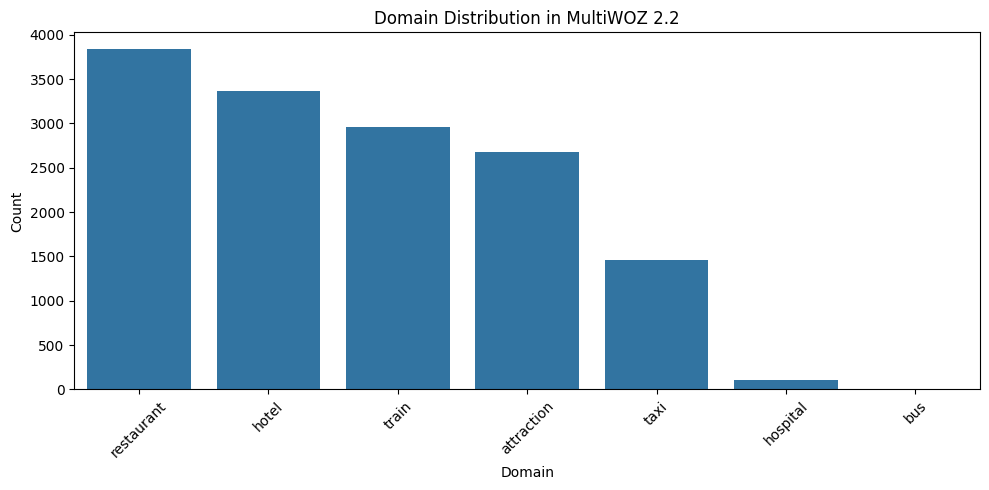

In [10]:
plt.figure(figsize=(10, 5))
sns.barplot(data=services_df.sort_values(by="Count", ascending=False), x="Domain", y="Count")
plt.title("Domain Distribution in MultiWOZ 2.2")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### AVG turns per Dialogue

       Turn Count
count         1.0
mean         10.0
std           NaN
min          10.0
25%          10.0
50%          10.0
75%          10.0
max          10.0


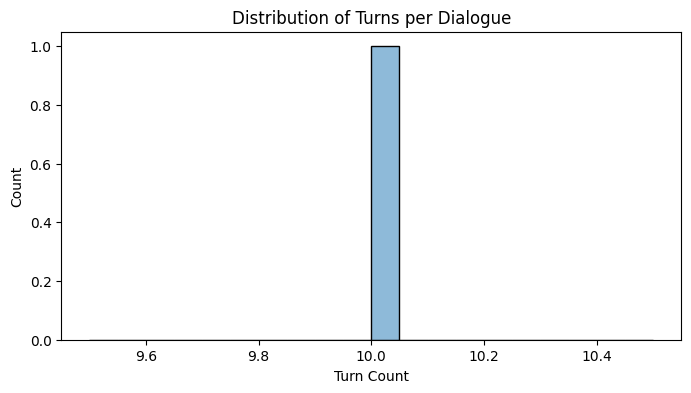

In [11]:
turns_df = pd.DataFrame(turn_per_dialogue, columns=["Turn Count"])
print(turns_df.describe())

# Optional plot
plt.figure(figsize=(8, 4))
sns.histplot(turns_df["Turn Count"], bins=20, kde=True)
plt.title("Distribution of Turns per Dialogue")
plt.show()

#### Top Domain Combinations

In [12]:
domains_df = pd.DataFrame(domains_in_dialogue).fillna("None")
top_combinations = domains_df.value_counts().head(10).reset_index(name="Count")
print(top_combinations)

            0           1      2     3  Count
0  restaurant        None   None  None   1270
1       train       hotel   None  None    925
2  attraction       train   None  None    823
3  restaurant       train   None  None    811
4       hotel        None   None  None    657
5  restaurant       hotel   None  None    506
6  attraction       hotel   None  None    481
7  restaurant  attraction   None  None    426
8        None        None   None  None    417
9  restaurant        taxi  hotel  None    376


#### Intent Frequency

In [13]:
from collections import Counter

intent_counter = Counter()

for dialogue in train_data.values():
    for turn in dialogue["turns"]:
        if turn["speaker"] == "USER":
            for frame in turn.get("frames", []):
                intent = frame.get("state", {}).get("active_intent", "NONE")
                if intent != "NONE":
                    intent_counter[intent] += 1

# Display top 10
for intent, count in intent_counter.most_common(10):
    print(f"{intent}: {count}")

find_restaurant: 10773
find_hotel: 10540
find_train: 9594
find_attraction: 8133
book_restaurant: 4409
book_hotel: 4403
find_taxi: 3695
book_train: 2409
find_hospital: 707
find_police: 477


#### Slot usage Frequency

In [14]:
from collections import Counter

slot_counter = Counter()

for dialogue in train_data.values():
    for turn in dialogue["turns"]:
        for frame in turn.get("frames", []):
            slot_values = frame.get("state", {}).get("slot_values", {})
            for slot, values in slot_values.items():
                slot_counter[slot] += len(values)

# Display top 15 most common slots
for slot, count in slot_counter.most_common(15):
    print(f"{slot}: {count}")

restaurant-food: 17225
train-destination: 16150
train-departure: 15851
train-day: 15710
restaurant-area: 15567
restaurant-pricerange: 15393
hotel-name: 14599
restaurant-name: 13632
hotel-area: 12164
hotel-type: 11459
attraction-type: 11117
hotel-pricerange: 11004
attraction-area: 10589
hotel-stars: 9921
restaurant-booktime: 9410


#### Requested Slot Frequency

In [15]:
requested_counter = Counter()

for dialogue in train_data.values():
    for turn in dialogue["turns"]:
        if turn["speaker"] == "USER":
            for frame in turn.get("frames", []):
                requested_slots = frame.get("state", {}).get("requested_slots", [])
                for slot in requested_slots:
                    requested_counter[slot] += 1

# Display top requested slots
for slot, count in requested_counter.most_common(10):
    print(f"{slot}: {count}")

restaurant-address: 1163
attraction-postcode: 1108
attraction-address: 1107
attraction-phone: 1059
restaurant-phone: 1047
attraction-entrancefee: 843
train-price: 775
train-ref: 705
restaurant-postcode: 663
train-duration: 597


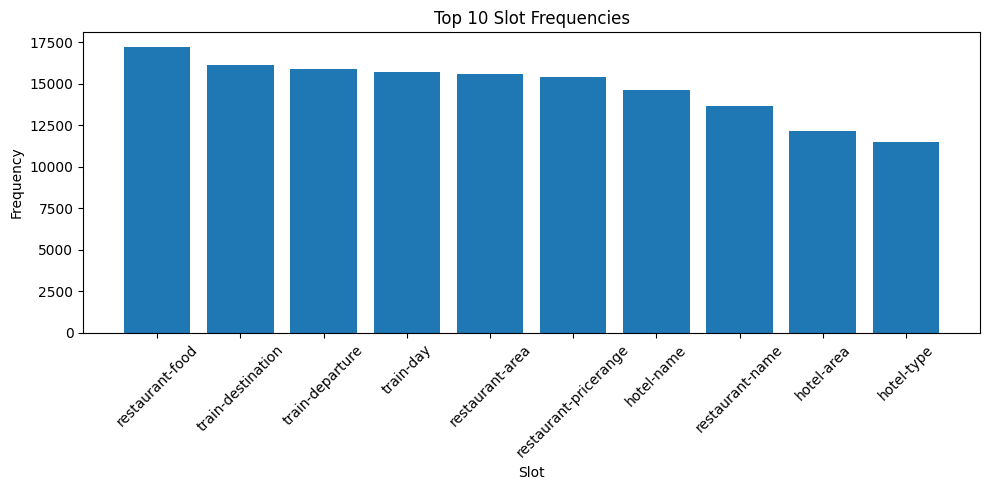

In [16]:
import matplotlib.pyplot as plt

top_slots = dict(slot_counter.most_common(10))
plt.figure(figsize=(10, 5))
plt.bar(top_slots.keys(), top_slots.values())
plt.xticks(rotation=45)
plt.title("Top 10 Slot Frequencies")
plt.xlabel("Slot")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#### Most Common System Utterance

In [17]:
from collections import Counter

system_utterances = Counter()

for d in train_data.values():
    for turn in d["turns"]:
        if turn["speaker"] == "SYSTEM":
            system_utterances[turn["utterance"].strip().lower()] += 1

# Top 10 most frequent system replies
for utt, count in system_utterances.most_common(10):
    print(f"{count} — {utt}")

114 — have a great day!
84 — you're welcome. have a great day!
80 — is there anything else i can help you with?
76 — thank you, goodbye.
72 — thank you for contacting us and have a nice day.
69 — is there anything else i can help you with today?
69 — you're welcome! have a great day!
69 — have a nice day.
69 — thank you for using our services.
66 — where will you be departing from?


#### AVG length of System Responses

In [21]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [22]:
lengths = []

for dialogue in train_data.values():
  for turn in dialogue["turns"]:
    if turn["speaker"] == "SYSTEM":
      tokens = word_tokenize(turn["utterance"])
      lengths.append(len(tokens))

avg_length = sum(lengths) / len(lengths)
print(f"Average length of system responses: {avg_length:.2f} words")

Average length of system responses: 17.23 words


#### System Slot Mentions

In [23]:
slot_mentions = Counter()

for d in train_data.values():
    for turn in d["turns"]:
        if turn["speaker"] == "SYSTEM":
            for frame in turn.get("frames", []):
                for slot in frame.get("slots", []):
                    slot_name = slot.get("slot")
                    if slot_name:
                        slot_mentions[slot_name] += 1

# Top mentioned slots by system
for slot, count in slot_mentions.most_common(10):
    print(f"{slot}: {count}")

restaurant-name: 2200
hotel-name: 2073
attraction-name: 994
taxi-departure: 305
taxi-destination: 270
train-leaveat: 105
restaurant-food: 88
train-arriveby: 59
taxi-arriveby: 32
restaurant-booktime: 17


#### System Responses with Recommendations

In [24]:
recommendations = []

for d in train_data.values():
    for turn in d["turns"]:
        if turn["speaker"] == "SYSTEM":
            for frame in turn.get("frames", []):
                for slot in frame.get("slots", []):
                    if slot.get("slot") == "restaurant-name":
                        recommendations.append(slot.get("value"))

print(f"Total restaurant names recommended: {len(set(recommendations))}")
print("Example recommendations:", recommendations[:10])

Total restaurant names recommended: 419
Example recommendations: ['Bedouin', 'the lucky star', 'Little Seoul', 'cotto', 'Charlie Chan', 'Yu Garden', 'city', 'Chiquito Restaurant Bar', 'Royal Spice', 'midsummer house restaurant']
